# **SW11: Hyperparameter tuning**

Hyperparameter tuning is the process of selecting the best set of hyperparameters for a machine learning model to improve its performance. Hyperparameters are external configurations, such as learning rate or regularization strength, that are set before training and significantly influence how well the model generalizes to new data. Tuning these parameters typically involves methods like grid search, random search, or Bayesian optimization.

---

## **Setup**


In [1]:
# Basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Some Jupyter magic for nicer output
%config InlineBackend.figure_formats = ["svg"]   # Enable vectorized graphics

# Adjust the default settings for plots
import sys
sys.path.append("..")
import ml
ml.setup_plotting()

In [2]:
# Install scikit-optimize (if you haven't already)
try:
    import skopt
except ImportError:
    %pip install scikit-optimize
    

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import the dependencies

import numpy as np
from time import time

# Load scikit-material
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

We will be working primarily with the Digit dataset in this notebook.
- 8x8 pixel images of handwritten digits 0-9
- 1797 samples
- 64 features (8x8 pixels, each pixel/grayscale value is a feature)
- 10 classes (digits 0-9)

More description: [Link](https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html)

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0


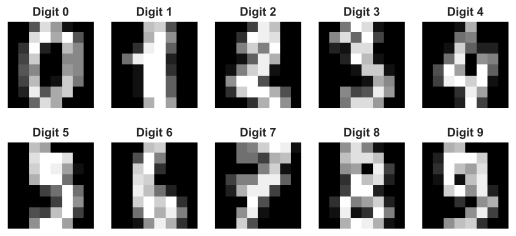

In [4]:
# Load the digits dataset
data = load_digits(n_class=10, as_frame=True)
X, y = data.data, data.target

# print(data.DESCR)
display(X)

# Display some of the cases...
fig, axes = plt.subplots(2, 5, figsize=(9, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X.iloc[i].values.reshape(8, 8), cmap="gray")
    ax.set_title(f"Digit {y.iloc[i]}")
    ax.axis("off")

In [6]:
# Split training and test data, as usual
random_state = 42
test_ratio = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.6, 
                                                    test_size=.25, 
                                                    random_state=0)

## **The baseline model**

We will be training an SVM model for classification. In scikit-learn, the 
corresponding object is called [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (support vector classification.

Let's first retrieve the hyperparameters of the model and their default values:

In [7]:
# Find all hyperparams of your model with get_params()
model = SVC()
model.get_params()


{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [8]:
# Default training and evaluation
model = SVC()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f"Default model test score: {score:.2f}")

Default model test score: 0.99


## **Method 1: Grid search**

(See lecture slides for how it works...)

In scikit-learn, the grid search method is implemented in the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class.
It takes a model and a dictionary of hyperparameters to search over. 

In [9]:
from sklearn.model_selection import GridSearchCV

# Specify the hyperparameters to search over.
# Use a full grid over all parameters
# Note how we can also include categorical parameters (see kernel)
param_grid = {
    'C': np.exp(np.linspace(-6, 6, num=3)), # log-uniform
    'gamma': np.exp(np.linspace(-6, 1, num=2)),
    'degree': [int(val) for val in np.linspace(1, 8, num=2)],
#    'degree': np.linspace(1, 8, num=2),  # integer valued parameter
    'kernel': ['linear', 'poly', 'rbf']  # categorical parameter
}

# Perform the search
grid_search = GridSearchCV(SVC(), param_grid=param_grid)
start = time()
result = grid_search.fit(X_train, y_train)

# Summarize result
print("Grid search - time: %.2fs" % (time() - start))
print("Grid search - best score: %.3f" % result.best_score_)
print("Grid search - best params: %s" % result.best_params_)
print("Grid search - test score: %s" % result.score(X_test, y_test))

Grid search - time: 8.94s
Grid search - best score: 0.983
Grid search - best params: {'C': 403.4287934927351, 'degree': 1, 'gamma': 0.0024787521766663585, 'kernel': 'rbf'}
Grid search - test score: 0.9888888888888889


## **Method 2: Random search**

Random search with RandomizedSearchCV behaves very similarly to GridSearchCV
but instead of trying all possible combinations, it tries a fixed number of them
randomly. This can be useful when the search space is very large, as it allows
to explore more of the space in the same amount of time.

In [10]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# We can specify distributions or lists of values for each parameter.
# RandomizedSearchCV will then sample uniformly from these distributions.
param_grid = {
    "C": stats.loguniform(1e-6, 1e6),
    "gamma": stats.loguniform(1e-6, 1e1),
    "degree": stats.randint(1, 8),
    "kernel": ['linear', 'poly', 'rbf']  # categorical parameter
}

# Perform the search
random_search = RandomizedSearchCV(SVC(), 
                                   param_distributions=param_grid, 
                                   n_iter=32, cv=3)

start = time()
random_result = random_search.fit(X_train, y_train)
print("Random search - time: %.2fs" % (time() - start))
print("Random search - best score: %.3f" % random_result.best_score_)
print("Random search - test params: %s" % random_result.best_params_)
print("Random search - test score: %.3f" % random_search.score(X_test, y_test))

Random search - time: 3.48s
Random search - best score: 0.985
Random search - test params: {'C': 351972.011291885, 'degree': 4, 'gamma': 8.23916229943161, 'kernel': 'poly'}
Random search - test score: 0.982


## **Method 3: Bayesian modelling**

Finally, the Bayesian optimization approach: It is a more advanced approach that uses a probabilistic model to predict the performance of the model for each hyperparameter configuration. This allows it to focus on the most promising configurations, and to explore the space based on the results of previous evaluations.

Here, we rely on the implementation in scikit-optimize: 
[BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)

In [11]:
from skopt import BayesSearchCV

# Again, we need to specify the search space for each parameter.
param_grid = {
    "C": stats.loguniform(1e-6, 1e6),
    "gamma": stats.loguniform(1e-6, 1e1),
    "degree": stats.randint(1, 8),
    "kernel": ['linear', 'poly', 'rbf']  # categorical parameter
}
param_grid = {
    "C": (1e-6, 1e+6, 'log-uniform'), # log-uniform: search over p = exp(x) by varying x
    "gamma": (1e-6, 1e+1, 'log-uniform'),
    "degree": (1, 8),  # integer valued parameter
    "kernel": ['linear', 'poly', 'rbf'],  # categorical parameter
}


opt = BayesSearchCV(
    SVC(),
    param_grid,
    n_iter=32,
    cv=3
)

# Note: This will take a while to run. (40s on my machine)
start = time()
opt.fit(X_train, y_train)
stop = time()

In [12]:
print("Bayes opt – time: %.2fs" % (stop - start))
print("Bayes opt - best score: %.3f" % opt.best_score_)
print("Bayes opt - best params: %s" % dict(opt.best_params_))
print("Bayes opt - test score: %.3f" % opt.score(X_test, y_test))

Bayes opt – time: 29.67s
Bayes opt - best score: 0.985
Bayes opt - best params: {'C': 1.0823611243664157, 'degree': 4, 'gamma': 0.06553052965736894, 'kernel': 'poly'}
Bayes opt - test score: 0.982


## **Discussion**
The different tuning methods have different trade-offs. Note 
that the Bayesian optimization method is the most computationally expensive
but also the most effective in terms of finding the best hyperparameters.
In the case of the digits dataset, the difference in performance is not
very large, in either of the cases. However, for more complex datasets, the
difference can be more significant.

<!-- TODO: Revise this text... -->